# Visual Defect Detection Using Transfer Learning
Description: This notebook implements a defect detection system using a pre-trained CNN (ResNet50) on the MVTec AD dataset.

## Step 1: Setup and Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Set path to your dataset folder
DATASET_PATH = '/content/drive/MyDrive/CSS586_Visual_Defect_Detection/datasets'


Mounted at /content/drive


In [2]:
# !pip install torchvision matplotlib scikit-learn

# Imports
import os
from glob import glob
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets
from torch.utils.data import DataLoader, random_split, Dataset
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score, ConfusionMatrixDisplay

import numpy as np
from PIL import Image
import seaborn as sns


# Single Item Category Model Training

## Step 2: Data Preparation
Since MVTec AD dataset only has `train/good`, `test/good`, `test/defective`, you have to load the MVTec AD dataset fully and then split into train, test and validation datasets using a stratified split.

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [4]:
class MVTecBinaryClassificationDataset(Dataset):
    def __init__(self, root_dir=None, item_names='all', transform=None, paths=None, labels=None):
        self.transform = transform
        self.classes = ['good', 'defective']

        # Direct mode: from path-label pairs
        if paths is not None and labels is not None:
            self.samples = paths
            self.labels = labels
            return

        # Otherwise use the default directory-based mode
        self.samples = []
        self.labels = []

        # List all items if 'all' is passed
        if item_names == 'all':
            item_names = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]

        if root_dir is None:
            raise ValueError("Must provide either (root_dir and item_names) or (paths and labels).")

        if isinstance(item_names, str):
            item_names = [item_names]  # Make it a list

        for item_name in item_names:
            base_path = os.path.join(root_dir, item_name)

            split = 'train'
            split_path = os.path.join(base_path, split)
            good_images = glob(os.path.join(split_path, 'good', '*.png'))
            self.samples += good_images
            self.labels += [0] * len(good_images)

            split = 'test'
            split_path = os.path.join(base_path, split)
            for defect_type in os.listdir(split_path):
                defect_path = os.path.join(split_path, defect_type)
                if not os.path.isdir(defect_path): continue
                images = glob(os.path.join(defect_path, '*.png'))
                label = 0 if defect_type == 'good' else 1
                self.samples += images
                self.labels += [label] * len(images)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path = self.samples[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

In [5]:
from sklearn.model_selection import train_test_split
item_name = 'bottle'  # Change this to the item you are evaluating
root_dir='/content/drive/MyDrive/CSS586_Visual_Defect_Detection/datasets/mvtec_anomaly_detection'

full_dataset = MVTecBinaryClassificationDataset(
    root_dir=root_dir,
    item_names=item_name,
    transform=None
)

class_2_id = {0:'good', 1:'defective'}

image_paths = full_dataset.samples
labels = full_dataset.labels

# First split: Train (80%) and temp (20%)
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42)

# Second split: Val (10%) and Test (10%) from temp
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)

# Datasets
train_dataset = MVTecBinaryClassificationDataset(paths=train_paths, labels=train_labels, transform=transform)
val_dataset = MVTecBinaryClassificationDataset(paths=val_paths, labels=val_labels, transform=transform)
test_dataset = MVTecBinaryClassificationDataset(paths=test_paths, labels=test_labels, transform=transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

# Show class mapping
print("Class indices:", class_2_id)

Class indices: {0: 'good', 1: 'defective'}


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [6]:
from collections import Counter

print("Train:", Counter(train_labels))
print("Val:", Counter(val_labels))
print("Test:", Counter(test_labels))

Train: Counter({0: 183, 1: 50})
Val: Counter({0: 23, 1: 6})
Test: Counter({0: 23, 1: 7})


##Step 3: Utility Functions
Define functions for getting, loading and saving checkpoints and metrics of the model in training.

In [7]:
import os
import re
import torch

CHECKPOINT_DIR = "/content/drive/MyDrive/CSS586_Visual_Defect_Detection/checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

In [8]:
def get_checkpoint_dir(experiment_name):
    base_dir = "/content/drive/MyDrive/CSS586_Visual_Defect_Detection/checkpoints"
    checkpoint_dir = os.path.join(base_dir, experiment_name)
    os.makedirs(checkpoint_dir, exist_ok=True)
    return checkpoint_dir

def load_latest_checkpoint(model, optimizer, experiment_name):
    checkpoint_dir = get_checkpoint_dir(experiment_name)
    checkpoints = [f for f in os.listdir(checkpoint_dir) if f.endswith(".pth")]
    if not checkpoints:
        print(f"No checkpoint found for '{experiment_name}'. Starting from scratch.")
        return model, optimizer, 0

    latest = max(checkpoints, key=lambda f: int(re.findall(r'\d+', f)[-1]))
    path = os.path.join(checkpoint_dir, latest)
    print(f"Loading checkpoint from: {path}")
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    return model, optimizer, start_epoch

def save_checkpoint(model, optimizer, epoch, experiment_name):
    checkpoint_dir = get_checkpoint_dir(experiment_name)
    save_path = os.path.join(checkpoint_dir, f'resnet_vdd_epoch_{epoch}.pth')
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, save_path)
    print(f"Saved checkpoint to: {save_path}")

In [9]:
import json
def get_metrics_path(experiment_name):
    checkpoint_dir = get_checkpoint_dir(experiment_name)
    return os.path.join(checkpoint_dir, "metrics.json")

def save_metrics(train_losses, train_accs, val_accs, experiment_name):
    path = get_metrics_path(experiment_name)
    with open(path, "w") as f:
        json.dump({
            "train_losses": train_losses,
            "train_accs": train_accs,
            "val_accs": val_accs
        }, f)
    print(f"Saved metrics to: {path}")

def load_metrics(experiment_name):
    path = get_metrics_path(experiment_name)
    if os.path.exists(path):
        with open(path, "r") as f:
            data = json.load(f)
        print(f"Loaded existing metrics from: {path}")
        return data["train_losses"], data["train_accs"], data["val_accs"]
    else:
        print(f"No previous metrics found for '{experiment_name}', starting fresh.")
        return [], [], []

## Step 4: Load and Fine-tune the Pre-trained Model

In [10]:
import torch
import torch.nn as nn
from torchvision import models

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load pre-trained ResNet-50
# model = models.resnet50(weights='IMAGENET1K_V1')
model = models.resnet50(pretrained=True)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace the final layer (fc) with a new classifier
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # 2 classes

# Move to GPU/CPU
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using device: cuda


## Step 5: Training Loop
Loading and saving checkpoints and metrics.

Implementing early stopping.

Saving final model.

In [11]:
def train(model, train_loader, val_loader, experiment_name, best_model_path, lr=0.001, num_epochs=5):
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.fc.parameters(), lr=lr)

    # Load the latest checkpoint and metrics
    model, optimizer, start_epoch = load_latest_checkpoint(model, optimizer, experiment_name)
    train_losses, train_accs, val_accs = load_metrics(experiment_name)

    # Early stopping config
    early_stop_patience = 5  # stop if no improvement after 3 epochs
    best_val_acc = max(val_accs) if val_accs else 0.0
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        # --- Training ---
        model.train()
        total_loss = 0
        total_train = 0
        correct_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Track training accuracy
            _, preds = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (preds == labels).sum().item()

        train_loss = total_loss / len(train_loader)
        train_losses.append(train_loss)

        train_acc = correct_train / total_train
        train_accs.append(train_acc)

        # --- Validation ---
        model.eval()
        total_val = 0
        correct_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (preds == labels).sum().item()

        val_acc = correct_val / total_val
        val_accs.append(val_acc)

        # Save checkpoint and metrics after each epoch
        save_checkpoint(model, optimizer, epoch+1, experiment_name)
        save_metrics(train_losses, train_accs, val_accs, experiment_name)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {total_loss/len(train_loader):.4f} - Train Acc: {train_acc:.4f} - Val Acc: {val_acc:.4f}")

        # --- Early Stopping Logic ---
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            epochs_no_improve = 0
            torch.save(model.state_dict(), best_model_path)
            print("✅ Best model updated.")

        else:
            epochs_no_improve += 1
            print(f"No improvement in val_acc for {epochs_no_improve} epoch(s)")

        if epochs_no_improve >= early_stop_patience:
            print(f"Early stopping triggered. Best val_acc: {best_val_acc:.4f}")
            break


In [12]:
experiment_name = "single_item_category".strip()
best_model_path = os.path.join(get_checkpoint_dir(experiment_name), f"best_model_{experiment_name}.pth")
train(model, train_loader, val_loader, experiment_name, best_model_path, 0.001, 10)

No checkpoint found for 'single_item_category'. Starting from scratch.
No previous metrics found for 'single_item_category', starting fresh.
Saved checkpoint to: /content/drive/MyDrive/CSS586_Visual_Defect_Detection/checkpoints/single_item_category/resnet_vdd_epoch_1.pth
Saved metrics to: /content/drive/MyDrive/CSS586_Visual_Defect_Detection/checkpoints/single_item_category/metrics.json
Epoch [1/10] - Loss: 0.6649 - Train Acc: 0.7811 - Val Acc: 0.7931
✅ Best model updated.
Saved checkpoint to: /content/drive/MyDrive/CSS586_Visual_Defect_Detection/checkpoints/single_item_category/resnet_vdd_epoch_2.pth
Saved metrics to: /content/drive/MyDrive/CSS586_Visual_Defect_Detection/checkpoints/single_item_category/metrics.json
Epoch [2/10] - Loss: 0.4884 - Train Acc: 0.7940 - Val Acc: 0.7931
No improvement in val_acc for 1 epoch(s)
Saved checkpoint to: /content/drive/MyDrive/CSS586_Visual_Defect_Detection/checkpoints/single_item_category/resnet_vdd_epoch_3.pth
Saved metrics to: /content/drive/My

In [13]:
# Save full model (architecture + weights)
# torch.save(model, f'/content/drive/MyDrive/CSS586_Visual_Defect_Detection/models/resnet50_{experiment_name}_model.pth')
# print(f"Model saved to /content/drive/MyDrive/CSS586_Visual_Defect_Detection/models/resnet50_{experiment_name}_model.pth")

Model saved to /content/drive/MyDrive/CSS586_Visual_Defect_Detection/models/resnet50_single_item_category_model.pth


## Step 6: Evaluation
Testing and evaluating performance on test set.

Metrics used: Test accuracy, Classification report, Confusion matrix, Precision and Recall.

In [14]:
def evaluate(model, test_loader, test_dataset):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    # Convert to arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    accuracy = accuracy_score(all_labels, all_preds)

    # Results
    print(f"Final Test Accuracy: {accuracy*100:.2f}%")

    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

    print("Confusion Matrix:")
    cm = confusion_matrix(all_labels, all_preds)
    print(cm)

    # Plot confusion matrix as image
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

    return all_preds,all_labels

In [15]:
def show_preds(model, loader, class_names, num_images=5):
    model.eval()
    shown = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for i in range(inputs.size(0)):
                image = inputs[i].cpu().permute(1, 2, 0).numpy()
                image = image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
                image = np.clip(image, 0, 1)

                plt.imshow(image)
                plt.title(f"True: {class_names[labels[i]]} | Pred: {class_names[preds[i]]}")
                plt.axis('off')
                plt.show()

                shown += 1
                if shown >= num_images:
                    return


Final Test Accuracy: 96.67%
Classification Report:
              precision    recall  f1-score   support

        good       0.96      1.00      0.98        23
   defective       1.00      0.86      0.92         7

    accuracy                           0.97        30
   macro avg       0.98      0.93      0.95        30
weighted avg       0.97      0.97      0.97        30

Confusion Matrix:
[[23  0]
 [ 1  6]]


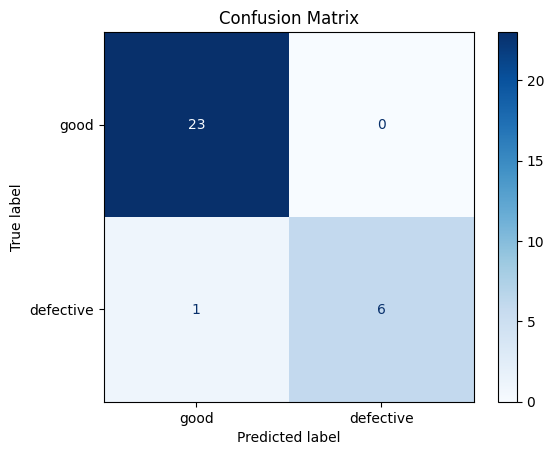

In [16]:
# Load the saved best model state dictionary
best_model_state_dict = torch.load(best_model_path, map_location=device)
model.load_state_dict(best_model_state_dict)
test_preds, test_labels = evaluate(model, test_loader, test_dataset)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


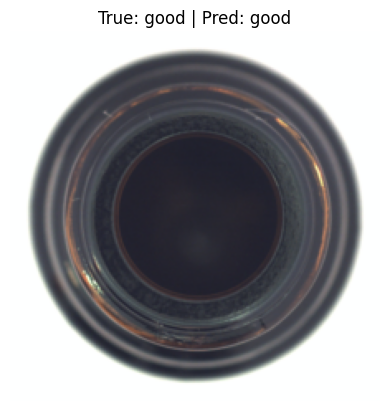

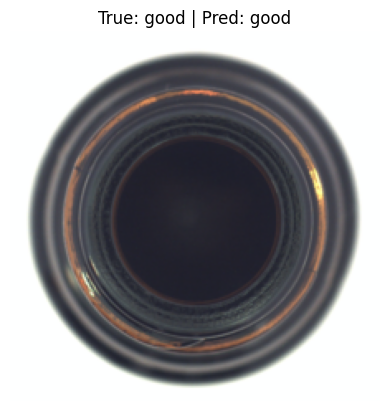

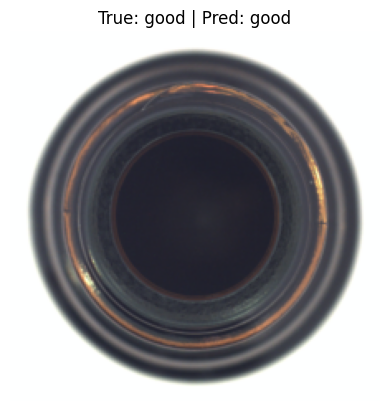

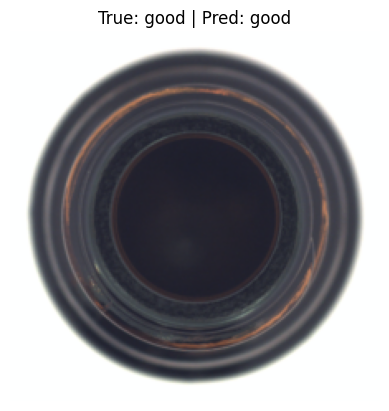

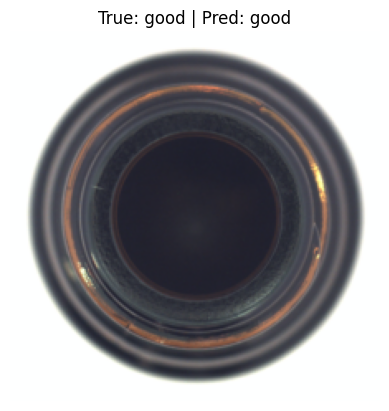

In [17]:
show_preds(model, test_loader, train_dataset.classes)

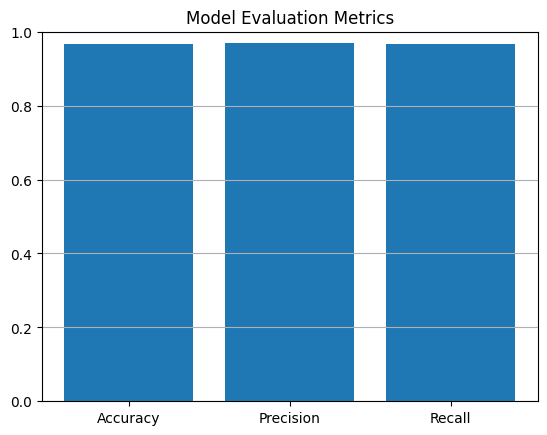

In [18]:
accuracy = accuracy_score(test_labels, test_preds)
precision = precision_score(test_labels, test_preds, average='weighted')
recall = recall_score(test_labels, test_preds, average='weighted')

plt.bar(['Accuracy', 'Precision', 'Recall'], [accuracy, precision, recall])
plt.title("Model Evaluation Metrics")
plt.ylim(0, 1)
plt.grid(True, axis='y')
plt.show()


# Multiple Item Category Training

## Step 2: Data Preparation
Using previously defined MVTecBinaryClassificationDataset class, load data and split into train, validation and test datasets (80:20:20)

In [19]:
item_name = 'all'

full_dataset = MVTecBinaryClassificationDataset(
    root_dir=root_dir,
    item_names=item_name,
    transform=None
)

image_paths = full_dataset.samples
labels = full_dataset.labels

# # First split: Train (80%) and temp (20%)
# train_paths, temp_paths, train_labels, temp_labels = train_test_split(
#     image_paths, labels, test_size=0.2, stratify=labels, random_state=42)

# # Second split: Val (10%) and Test (10%) from temp
# val_paths, test_paths, val_labels, test_labels = train_test_split(
#     temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)

# Datasets
train_dataset = MVTecBinaryClassificationDataset(paths=train_paths, labels=train_labels, transform=transform)
val_dataset = MVTecBinaryClassificationDataset(paths=val_paths, labels=val_labels, transform=transform)
test_dataset = MVTecBinaryClassificationDataset(paths=test_paths, labels=test_labels, transform=transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

# Show class mapping
print("Classes:", train_dataset.classes)
print("Total Images:", len(train_dataset)+len(val_dataset)+len(test_dataset))
print("Class indices:", class_2_id)

Classes: ['good', 'defective']
Total Images: 292
Class indices: {0: 'good', 1: 'defective'}


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [20]:
from collections import Counter

print("Train:", Counter(train_labels))
print("Val:", Counter(val_labels))
print("Test:", Counter(test_labels))


Train: Counter({0: 183, 1: 50})
Val: Counter({0: 23, 1: 6})
Test: Counter({np.int64(0): 23, np.int64(1): 7})


## Step 3: Load and Fine-tune the Pre-trained Model

In [21]:
from torchvision import models
import torch.nn as nn
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load pre-trained ResNet-50
model = models.resnet50(weights='IMAGENET1K_V1')  # New way instead of pretrained=True

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace classifier
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # 2 classes: defective, good

# Move to GPU/CPU
model = model.to(device)


Using device: cuda


## Step 4: Training Loop
Loading and saving checkpoints and metrics.

Implementing early stopping.

Saving final model.

In [22]:
experiment_name = "multi_item_category".strip()
best_model_path = os.path.join(get_checkpoint_dir(experiment_name), f"best_model_{experiment_name}.pth")
train(model, train_loader, val_loader, experiment_name, best_model_path, 0.001, 15)

No checkpoint found for 'multi_item_category'. Starting from scratch.
No previous metrics found for 'multi_item_category', starting fresh.
Saved checkpoint to: /content/drive/MyDrive/CSS586_Visual_Defect_Detection/checkpoints/multi_item_category/resnet_vdd_epoch_1.pth
Saved metrics to: /content/drive/MyDrive/CSS586_Visual_Defect_Detection/checkpoints/multi_item_category/metrics.json
Epoch [1/15] - Loss: 0.5847 - Train Acc: 0.7039 - Val Acc: 0.7931
✅ Best model updated.
Saved checkpoint to: /content/drive/MyDrive/CSS586_Visual_Defect_Detection/checkpoints/multi_item_category/resnet_vdd_epoch_2.pth
Saved metrics to: /content/drive/MyDrive/CSS586_Visual_Defect_Detection/checkpoints/multi_item_category/metrics.json
Epoch [2/15] - Loss: 0.4955 - Train Acc: 0.7854 - Val Acc: 0.7931
No improvement in val_acc for 1 epoch(s)
Saved checkpoint to: /content/drive/MyDrive/CSS586_Visual_Defect_Detection/checkpoints/multi_item_category/resnet_vdd_epoch_3.pth
Saved metrics to: /content/drive/MyDrive/C

In [23]:
# Save full model (architecture + weights)
# torch.save(model, f'/content/drive/MyDrive/CSS586_Visual_Defect_Detection/models/resnet50_{experiment_name}_model.pth')
# print(f"Model saved to /content/drive/MyDrive/CSS586_Visual_Defect_Detection/models/resnet50_{experiment_name}_model.pth")

Model saved to /content/drive/MyDrive/CSS586_Visual_Defect_Detection/models/resnet50_multi_item_category_model.pth


## Step 5: Evaluation
Testing and evaluating performance on test set.

Metrics used: Test accuracy, Classification report, Confusion matrix, Precision and Recall.

Final Test Accuracy: 86.67%
Classification Report:
              precision    recall  f1-score   support

        good       0.85      1.00      0.92        23
   defective       1.00      0.43      0.60         7

    accuracy                           0.87        30
   macro avg       0.93      0.71      0.76        30
weighted avg       0.89      0.87      0.85        30

Confusion Matrix:
[[23  0]
 [ 4  3]]


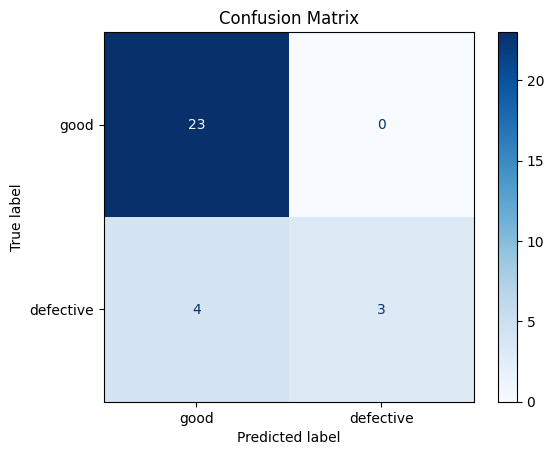

In [24]:
best_model_state_dict = torch.load(best_model_path, map_location=device)
model.load_state_dict(best_model_state_dict)
test_preds, test_labels = evaluate(model, test_loader, test_dataset)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


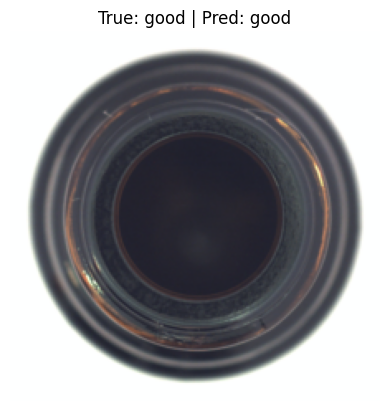

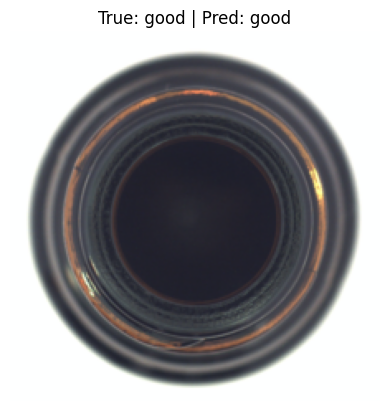

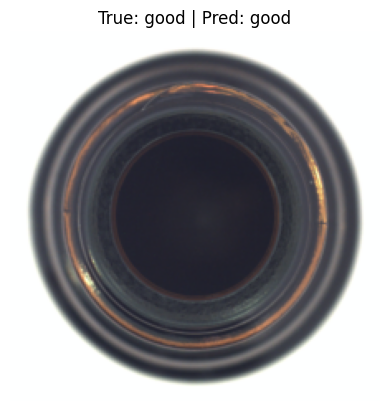

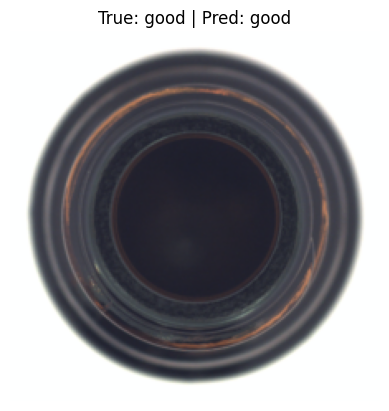

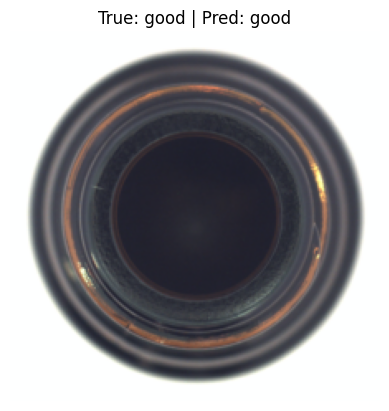

In [25]:
show_preds(model, test_loader, train_dataset.classes)

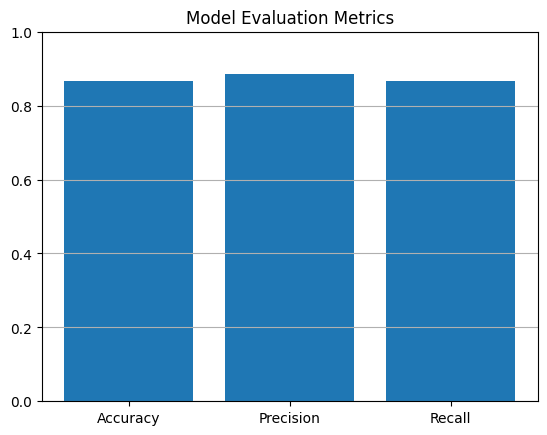

In [26]:
accuracy = accuracy_score(test_labels, test_preds)
precision = precision_score(test_labels, test_preds, average='weighted')
recall = recall_score(test_labels, test_preds, average='weighted')

plt.bar(['Accuracy', 'Precision', 'Recall'], [accuracy, precision, recall])
plt.title("Model Evaluation Metrics")
plt.ylim(0, 1)
plt.grid(True, axis='y')
plt.show()
